# Medicare Claims Data Analysis Project Goals:

* Connect to an external/3rd party API and read data into your app

* Create and call at least 3 functions, at least one of which must return a value that is used

* Calculate and display data based on an external factor (ex: get the current date, and display how many days remaining until some event) **Possibly

* Analyze text/data and display information about it (ex: how many words in a paragraph)

* Visualize data in a graph, chart, or other visual representation of data


In [168]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

# pd.set_option('display.max_rows', None)

## Connect to an external/3rd party API and read data into your app

### Medicare Data Set of Surgical HCPCS Codes Reported on Claims, 2015-2017

* CMS API Endpoint, 2015: https://data.cms.gov/resource/uqfq-w9cg.json
* CMS API Endpoint, 2016: https://data.cms.gov/resource/jtra-d83c.json
* CMS API Endpoint, 2017: https://data.cms.gov/resource/2zuc-y5mm.json
* API Documentation, 2015: https://dev.socrata.com/foundry/data.cms.gov/uqfq-w9cg
* API Documentation, 2016: https://dev.socrata.com/foundry/data.cms.gov/jtra-d83c
* API Documentation, 2017: https://dev.socrata.com/foundry/data.cms.gov/2zuc-y5mm
* Was able to use documentation to format the below SoQL query within my link to get a specific set of HPCPCS Codes (10004 - 69990, surgical codes):
"https://data.cms.gov/resource/2zuc-y5mm.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 "

## Create and call at least 3 functions, at least one of which must return a value that is used
* The below cell will run everything we need to format and consolidate our data that we will be using for all three years.
* The functions below will: 
    1. Return the raw API data (get_api_data)
    2. Data is then passed through pd.Dataframe.covert_dtypes method to covert dtypes to appropriate dtype.
    3. Newly formatted columns can be used to add columns with information needed for analysis, e.g. total amounts (add_totals_columns).
    4. Finally, the aggregate_data function will be aggregate data by hcpcs code, returning only one HCPCS code column with numerical values being added (if totals) or averaged (if reporting an average).    
* From there, the data can be concatenated into one master dataframe that is ready to be analyzed.

* Note: the last function is needed because the original data set returned multiple HCPCS values per place of service, and our analysis is looking (at least initially) to flatten out HCPCS codes while keeping the numerical data intact.

In [169]:
### ALL FUNCTIONS


# Function that will retrieve raw data that can be read into dataframe.
def get_api_data(url):
    request = requests.get(url)
    return request.content


# Function that will add columns needed for each dataframe that can be used for further analysis.
def add_totals_columns (df, year):
    df["total_billed_amount"] = df["number_of_services"] * df["average_medicare_allowed_amount"]
    df["total_amount_paid"] = df["number_of_services"] * df["average_medicare_payment_amount"]
    df["total_cost_to_patient"] = df["number_of_services"] * (df["average_medicare_allowed_amount"] - df["average_medicare_payment_amount"])
    return df


# Function that will aggregate data, allowing combination of data by HCPCS code to eliminate multiple codes in data set.
def aggregate_data(df):
    aggregation_instructions = {'hcpcs_description': 'first',
                            'hcpcs_drug_indicator': 'first',
                            'number_of_providers': 'sum',
                            'number_of_services' : 'sum',
                            'number_of_distinct_medicare_beneficiary_per_day_services': 'sum',
                            'average_submitted_charge_amount': 'mean',
                            'average_medicare_allowed_amount': 'mean',
                            'average_medicare_payment_amount': 'mean',
                            'total_billed_amount': 'sum',
                            'total_amount_paid': 'sum',
                            'total_cost_to_patient': 'sum',                         
                           }
    return df.groupby('hcpcs_code').aggregate(aggregation_instructions)


# Function using outer join to gather information regarding changes (delta) from year to year.
# fillna() method allows us to fill in all "NaN" or "<NA>" data so we can add/subtract data properly.    
def get_delta(df1, df2):
    join = pd.merge(df1, df2, how = 'outer', on=['hcpcs_code'])

    join = join[['number_of_services_x', 
                 'total_billed_amount_x', 
                 'total_amount_paid_x',
                 'total_cost_to_patient_x',
                 'number_of_services_y',
                 'total_billed_amount_y',
                 'total_amount_paid_y',
                 'total_cost_to_patient_y'
                ]].fillna(0)

    join['number_of_services_delta'] = join['number_of_services_x'] - join['number_of_services_y']
    join['total_billed_amount_delta'] = join['total_billed_amount_x'] - join['total_billed_amount_y']
    join['total_amount_paid_delta'] = join['total_amount_paid_x'] - join['total_amount_paid_y']
    join['total_cost_to_patient_delta'] = join['total_cost_to_patient_x'] - join['total_cost_to_patient_y']
                                                                                 
    return join[['number_of_services_delta', 
                 'total_billed_amount_delta', 
                 'total_amount_paid_delta',
                 'total_cost_to_patient_delta'
               ]]


# Function to use after join on HCPCS Codes that will re-establish index for easier slicing while retaining 'hcpcs_code' column.
def get_new_index(df):
    codes = df.index
    codes = codes.astype(int)
    index = np.array(list(range(0,len(df))))
    new_df = df.set_index(index)
    new_df.insert(0, 'hcpcs_code', codes)
    
    return new_df




In [170]:
# API Calls
df_2015 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/uqfq-w9cg.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2015)
df_2016 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/jtra-d83c.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2016)
df_2017 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/2zuc-y5mm.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2017)

In [171]:
# Using Functions to return main dataframe with all data and "delta" dataframes of year-to-year changes.

df_2015_agg = aggregate_data(df_2015)
df_2016_agg = aggregate_data(df_2016)
df_2017_agg = aggregate_data(df_2017)

d2016 = get_delta(df_2016_agg, df_2015_agg)
delta2016 = get_new_index(d2016)

d2017 = get_delta(df_2017_agg, df_2016_agg)
delta2017 = get_new_index(d2017)


frames = [df_2015_agg, df_2016_agg, df_2017_agg]
df = reduce(lambda  left,right: pd.merge(left,right,on=['hcpcs_code'], how='outer'), frames)
df = get_new_index(df)

In [172]:
# Formatting main dataframe columns for easier use.

descriptions = df['hcpcs_description_y']
descriptions2 = df['hcpcs_description']
df['hcpcs_description_x'] = df['hcpcs_description_x'].fillna(descriptions)
df['hcpcs_description_x'] = df['hcpcs_description_x'].fillna(descriptions2)

df = df.drop([
    'number_of_distinct_medicare_beneficiary_per_day_services_x',
    'average_submitted_charge_amount_x',
    'hcpcs_description_y',
    'number_of_distinct_medicare_beneficiary_per_day_services_y',
    'average_submitted_charge_amount_y',
    'hcpcs_description',
    'number_of_distinct_medicare_beneficiary_per_day_services',
    'average_submitted_charge_amount'    
], axis=1)

df = df.rename(columns = {
    'hcpcs_code': "HCPCS Code",
    'hcpcs_description_x': 'Code Description',
    'number_of_providers_x': 'Number of Providers - 2015',
    'number_of_services_x': 'Number of Services - 2015',
    'average_medicare_allowed_amount_x': 'Average Allowed Amount - 2015',
    'average_medicare_payment_amount_x': 'Average Payment Amount - 2015',
    'total_billed_amount_x': 'Total Billed Amount - 2015',
    'total_amount_paid_x': 'Total Amount Paid - 2015',
    'total_cost_to_patient_x': 'Total Cost to Patient - 2015',
    'number_of_providers_y': 'Number of Providers - 2016',
    'number_of_services_y': 'Number of Services - 2016',
    'average_medicare_allowed_amount_y': 'Average Allowed Amount - 2016',
    'average_medicare_payment_amount_y': 'Average Payment Amount - 2016',
    'total_billed_amount_y': 'Total Billed Amount - 2016',
    'total_amount_paid_y': 'Total Amount Paid - 2016',
    'total_cost_to_patient_y': 'Total Cost to Patient - 2016',
    'number_of_providers': 'Number of Providers - 2017',
    'number_of_services': 'Number of Services - 2017', 
    'average_medicare_allowed_amount': 'Average Allowed Amount - 2017',
    'average_medicare_payment_amount': 'Average Payment Amount - 2017',
    'total_billed_amount': 'Total Billed Amount - 2017',
    'total_amount_paid': 'Total Amount Paid - 2017',
    'total_cost_to_patient': 'Total Cost to Patient - 2017'
})

In [174]:
df

HCPCS Code                                   Code Description  \
0          10021                            Fine needle aspiration    
1          10022     Fine needle aspiration using imaging guidance    
2          10030  Fluid collection drainage by catheter using im...   
3          10040                                      Acne surgery    
4          10060                               Drainage of abscess    
5          10061                      Drainage of multiple abscess    
6          10080                         Drainage of tailbone cyst    
7          10081                         Drainage of tailbone cyst    
8          10120  Removal of foreign body from tissue, accessed ...   
9          10121  Removal of foreign body from tissue, accessed ...   
10         10140           Drainage of blood or fluid accumulation    
11         10160  Aspiration of abscess, blood accumulation, bli...   
12         10180         Drainage of wound infection after surgery    
13         11000  Removal of inflamed or infected skin, up to 10...   
14         11001              Removal of inflamed or infected skin    
15         11004  Removal of infected skin, tissue or muscle of ...   
16         11005  Removal of infected skin, tissue or muscle of ...   
17         11006  Removal of infected skin, tissue or muscle of ...   
18         11008  Removal of infected artificial material or mes...   
19         11010  Removal of foreign material from skin and tiss...   
20         11011  Removal of foreign material from skin, tissue,...   
21         11012  Removal of foreign material from skin, tissue,...   
22         11042  Removal of skin and tissue first 20 sq cm or l...   
23         11043  Removal of skin and/or muscle first 20 sq cm o...   
24         11044   Removal of skin and bone first 20 sq cm or less    
25         11045                        Removal of skin and tissue    
26         11046                     Removal of skin and/or muscle    
27         11047                          Removal of skin and bone    
28         11055           Removal of single thickened skin growth    
29         11056          Removal of 2 to 4 thickened skin growths    
30         11057     Removal of more than 4 thickened skin growths    
31         11100     Biopsy of single growth of skin and/or tissue    
32         11101  Biopsy of each additional growth of skin and/o...   
33         11200       Removal of up to and including 15 skin tags    
34         11201                              Removal of skin tags    
35         11300  Shaving of 0.5 centimeters or less skin growth...   
36         11301  Shaving of 0.6 centimeters to 1.0 centimeters ...   
37         11302  Shaving of 1.1 to 2.0 centimeters skin growth ...   
38         11303  Shaving of over 2.0 centimeters skin growth of...   
39         11305  Shaving of 0.5 centimeters or less skin growth...   
40         11306  Shaving of 0.6 centimeters to 1.0 centimeters ...   
41         11307  Shaving of 1.1 to 2.0 centimeters skin growth ...   
42         11308  Shaving of over 2.0 centimeters skin growth of...   
43         11310  Shaving of 0.5 centimeters or less skin growth...   
44         11311  Shaving of 0.6 centimeters to 1.0 centimeters ...   
45         11312  Shaving of 1.1 to 2.0 centimeters skin growth ...   
46         11313  Shaving of over 2.0 centimeters skin growth of...   
47         11400  Removal of growth (0.5 centimeters or less) of...   
48         11401  Removal of growth (0.6 to 1.0 centimeters) of ...   
49         11402  Removal of growth (1.1 to 2.0 centimeters) of ...   
50         11403  Removal of growth (2.1 to 3.0 centimeters) of ...   
51         11404  Removal of growth (3.1 to 4.0 centimeters) of ...   
52         11406  Removal of growth (4.0 centimeters) of the tru...   
53         11420  Removal of growth (0.5 centimeters or less) of...   
54         11421  Removal of growth (0.6 to 1.0 centimeters) of ...   
55         11422  Removal of g

## Analyze text/data and display information about it

### What questions can I use this data set to answer?

* What surgical procedures were most common in from 2015-2017?
* What surgical procedures, overall, cost Medicare the most?
* What procedures were least covered (i.e. where discrepancy between charges and amount paid was greatest).
* What types of procedures are most common (can organize by specialty or by surgery method, etc.)
* What health problems does this analysis bring up and how can we solve them?

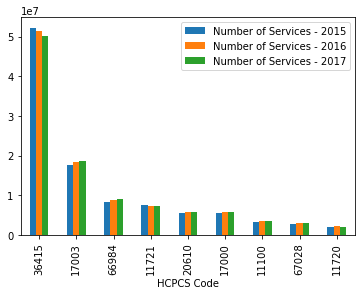

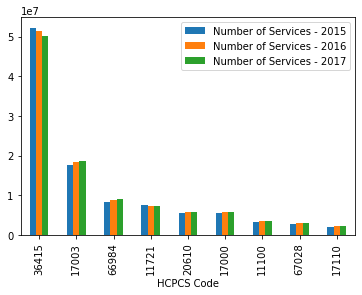

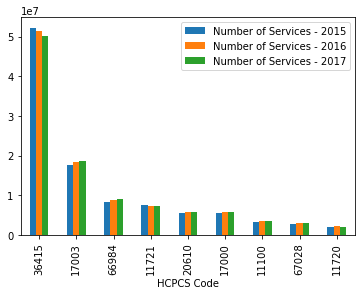

In [182]:
# What surgical procedures were most common in from 2015-2017?

df_by_count_2015 = df.sort_values(by=['Number of Services - 2015'], ascending=False)[['HCPCS Code', 'Number of Services - 2015', 'Number of Services - 2016', 'Number of Services - 2017']]
df_by_count_2016 = df.sort_values(by=['Number of Services - 2016'], ascending=False)[['HCPCS Code', 'Number of Services - 2015', 'Number of Services - 2016', 'Number of Services - 2017']]
df_by_count_2017 = df.sort_values(by=['Number of Services - 2015'], ascending=False)[['HCPCS Code', 'Number of Services - 2015', 'Number of Services - 2016', 'Number of Services - 2017']]

df_by_count_2015[0:9].plot.bar(x = "HCPCS Code")
df_by_count_2016[0:9].plot.bar(x = "HCPCS Code")
df_by_count_2017[0:9].plot.bar(x = "HCPCS Code")






## Visualize data in a graph, chart, or other visual representation of data

* Will need to import library (such as matplotlib) for visualization) and find ways to use that.

## Other Goals

* Calculate and display data based on an external factor (ex: get the current date, and display how many days remaining until some event) **Possibly

Will evaluate these to see if they would be practical in this project.